In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

In [4]:
# Load your dataset
data = pd.read_csv('github_data/merged_data_for_analysis.csv')

# Drop the unique identifier columns
data_Nan = data.drop(['CBG_ID','TRACT_ID','TRACTCE', 'COUNTYFP', 'BLKGRPCE'], axis=1)

data_cleaned = data_Nan.dropna()

### First Clustering: 3-dim PCA then GMM with 5 clusters

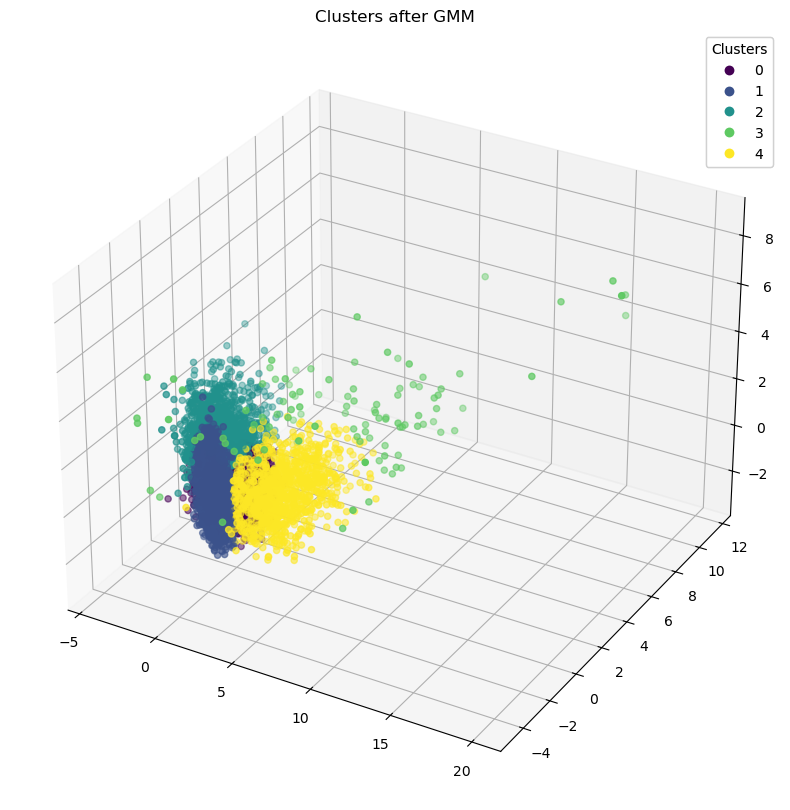

In [5]:
# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data_cleaned)

# Apply PCA to reduce dimensions to 3
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_normalized)

# Fit a Gaussian Mixture Model
# Choose the number of components based on your data and domain knowledge
gmm = GaussianMixture(n_components=5, covariance_type='full', random_state=42)
gmm.fit(data_pca)

# Predict the clusters
labels = gmm.predict(data_pca)

# Plot the results
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=labels, cmap='viridis')
legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)
plt.title('Clusters after GMM')
plt.show()

# Optionally, examine the PCA and GMM performance further, or adjust the number of GMM components
